**COMP3670 Assignment 4 - PCA & Dimensionality Reduction**
---

**Enter Your Student ID:** u7351505

**Your Name:** Yifan Luo
    

**Submit:** You can write your answers in this file and submit a single Jupyter Notebook file (.ipynb) on Wattle. Rename this file with your student number as 'uXXXXXXX.ipynb'. Otherwise, you can write your programming questions in this file, and submit two files, 'uXXXXXXX.ipynb' for programming and 'uXXXXXXX.pdf' for theory. Please submit them separately instead of a zip file.
    
**Enter Discussion Partner IDs Below:**
- <Enter ID 1>
- <Enter ID 2>
- <Enter ID 3>

**Enter The URLs You Referred To:**
- <URL 1>
- <URL 2>
- <URL 3>
    

**Programming Section**
- 1.1 15%
- 1.2 20%
- 1.3 15%
- 1.4 15%
- 1.5 15%
- 2. 20%

---


**PROGRAMMING SECTION**
---

For all of the following, program the solution yourself. Don't just call a library function that does the whole question for you, or you'll get zero (no, that doesn't mean you can't use any library functions, but it does mean that you have to show you understand how to compute the answer yourself).

**All written answers** should be between 50 and 500 words. If you can describe all the necessary information in 50 words, that's better. However, you'll only be graded on whether you describe the necessary ideas.


-----------

   **TASK 0.1:** You know the drill. Import Numpy and PyPlot.


-----------

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #This is for 3d scatter plots.
import math
import random
import os
import scipy
from matplotlib.pyplot import imread
from PIL import Image
np.random.seed(13579201)

Let's understand the settings of datasets.

---
We provide you with 3 pedestrian image folders, 'train', 'gallery', and 'val_query'. There are 199 images in 'train' which are used to compute the eigen pedestrians and build the projection matrix. 'Gallery' contains 90 images which belong to 15 different pedestrians. 'Val_query' has 3 images of 3 pedestrians. If two images' file name have same first four digits, then these two images belong to same pedestrian.

(24576, 199)


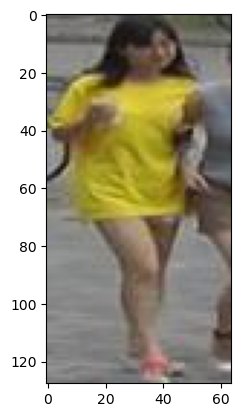

In [22]:
width = 64
height = 128
dimension = (height, width, 3)
images = []
filename = []
for file in os.listdir("./train"):
    if file.endswith(".jpg"):
        im = imread("./train/" + file)
        im = im.flatten() # flatten im into a vector
        images.append(im) 
        filename.append(file)
A_pp = np.stack(images).T # build a matrix where each column is a flattened image
print(A_pp.shape)
plt.imshow(A_pp[:, 0].reshape(dimension))
plt.show()

---

**TASK 1.1:** Let $A\_{pp} \in \mathbb{R}^{D \times N}$ be a matrix of data. Each column of $A\_{pp}$ is a sample of data (1 example for instance). The rows of $A\_{pp}$ are thus the features (dimensions) of each of these samples. Complete the function $preprocess(A\_{pp}) = A, Q\_norms, A\_means$, for which:

$$Q_{i,:} = A\_{pp}_{i,:} - \mu_i$$

...where $\mu_i = \frac{1}{m}\sum_j A\_{pp}_{ij}$ .

$$A_{i,:} = \frac{Q_{i,:}}{||Q_{i,:}||_\infty }$$


$A \in \mathbb{R}^{D \times N}$

$Q_{i,:}$ is the $i^{th}$ row of $Q$.

$A_{i,:}$ is the $i^{th}$ row of $A$.

$||Q_{i,:}||_\infty$ is the infinity norm of $Q_{i,:}$.

$Q\_norms \in \mathbb{R}^{D}$ is a vector recording $||Q_{i,:}||_\infty$ for every feature dimension $i$.

$A\_means \in \mathbb{R}^{D}$ is a vector recording $\mu_i$ for every feature dimension $i$.


**HINT:** 
- If the norm is 0, divide by 1 instead.

---

In [23]:
def preprocess(A_pp):
    # YOUR CODE HERE
    D, N = A_pp.shape  # D = 24576 (features), N = 199 (images)
    
    Q = A_pp - A_pp.mean(axis=1).reshape(-1, 1)  # 24576 * 199
    Q_norms = np.abs(Q).max(axis=1)  # 1 * 24576
    A = Q / np.where(Q_norms == 0, 1, Q_norms).reshape(-1, 1)  # 24576 * 199, preprocessed A_pp: subtract mean and scaled
    A_means = A_pp.mean(axis=1)  # 1 * 24576, means of each feature

    return A, Q_norms, A_means

A, Q_norms, A_means = preprocess(A_pp)
print(A)
print(Q_norms)
print(A_means.shape)

[[ 0.03106687  0.45122372  0.04821613 ... -0.68062737  0.05679076
  -0.20044812]
 [ 0.03929306  0.45699173  0.12283279 ... -0.64573276  0.07270895
  -0.18626422]
 [ 0.06112305  0.4970302   0.09465437 ... -0.60950335  0.09465437
  -0.10653355]
 ...
 [-0.13510982  0.39856121  0.02583858 ...  0.19525796 -0.07581304
  -0.00804529]
 [-0.12063572  0.34422058  0.0536854  ...  0.19480249 -0.13723773
   0.00387936]
 [-0.09488669  0.322213    0.0615257  ...  0.14842147 -0.13833457
   0.03545697]]
[116.62311558 119.70351759 119.29145729 ... 118.05025126 120.46733668
 115.08040201]
(24576,)


---

$A \in \mathbb{R}^{D \times N}$ as above is a matrix of data where every column is a sample of data, and every row is a feature of that data. In this case, we're going to be working with images. Each column $A_{:,j}$ of $A$ is an image of a pedestrian. 

"But an image is a square grid with three color channels" you might be thinking. Well, we've simply taken every column of the image and stacked them vertically, converting a 64 column $ \times $ 128 row pixel image with 3 channels into a vector which length is 24576.

Hence $D = 24576$ and we have $N = 199$ images.

Our objective is to describe each image of a pedestrian as a linear combination of other images. These other images are called Eigen Pedestrians. The Eigen Pedestrians, when flattenned into a column vector, is 24576 dimensional. These vectors are the Eigenvectors of the matrix $AA^T$.

---

**TASK 1.2:** Use $np.linalg.eig()$ and the functions you defined above to complete the function $eigen\_person(A) = F, D$.

$D$ is the matrix of eigen values. 

$F$ is the eigen pedestrians.

Make sure you preprocess the data.

**HINT:** 
- You'll need to ensure the columns of $F$ are unit vectors.
- np.cov()
- np.linalg.eig()
- Matrix size is a big issue when calculating the eigen values. You need to make sure it won't take too much **space or time**.
- If you've computed things correctly, all your eigen values should be real numbers (the imaginary components should be 0). Thus, you can ignore the error about imaginary / complex values.

---

Orthogonality Check (should be close to 0):  -5.828670879282072e-16
Unit Vector Check:  True
(24576, 199)
(24576,)
Visualise an Eigen Pedestrain:


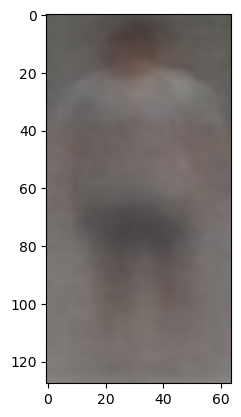

In [24]:
def eigen_ped(A):
    # YOUR CODE HERE
    # describe each image (pedestrian) as a linear combination of other images (eigen pedestrians, eigenvectors of AA.T)
    eig_values, V = np.linalg.eig(A.T @ A / A.shape[0])  # 1 * 199, 199 * 199
    sigma = np.sqrt(eig_values)  # 1 * 199
    F = A @ V / sigma  # 24576 * 199
    F /= np.linalg.norm(F, axis=0)  # 24576 * 199, eigenvectors / eigen pedestrians
    D = np.pad(eig_values, (0, A.shape[0] - len(eig_values)),  'constant', constant_values=0)  # 1 * 24576, eigenvalues

    return F, D
    

#For the purposes of doing this assignment, this code isn't really here. Pretend it's engraved in rock.
F, D = eigen_ped(A)
F_real = np.real(F)
print('Orthogonality Check (should be close to 0): ', F_real[:, 0].T@F_real[:, 1])
print('Unit Vector Check: ', math.isclose(np.linalg.norm(F_real[:,0]), 1))
print(F.shape) # It should be (24576, 199)
print(D.shape) # It should be (24576)

# The visulisation of an Eigen Pedestrain should **look like** a pedestrain.
print('Visualise an Eigen Pedestrain:')
ep = np.rint((F[:,0] * Q_norms + A_means).reshape(dimension)).astype(int)
plt.imshow(ep)
plt.show()

---

Recall the lecture, in which we rotated a vector until we found the largest value for the projection of the data onto that vector.

This was the eigen vector corresponding to the largest eigen value of that dataset. It was the "direction of greatest variance".

An eigen value $d_j$ in the $j^{th}$ column of $D$ (the matrix of eigen values), is associated with an eigen vector (or eigen pedestrian) in the $j^{th}$ column $f_j$ of $F$.

The variance of the data in the direction of $f_j$ is exactly $d_j$. So the $\sum_j d_j$ is the total variance of the dataset in all directions.

When we project the dataset onto an eigen pedestrian $f_k$, we "capture" a percentage of this variance $\frac{d_k}{\sum_j d_j}$. For example, if $\sum_j d_j = 100$, and we project our data on to the 2 eigen pedestrians $f_1$ and $f_2$ with corresponding eigen values $d_1 = 19$ and $d_2 = 3$, then we've captured $\frac{22}{100} = 22\%$ of the variance of the dataset.

---

**TASK 1.3:** Complete the function: 

$$reduce\_dimensionality(image\_vector, k, F, D, A\_means, Q\_norms) = compressed\_image, p$$

This function projects an image vector onto the $k$ eigen pedestrians corresponding to the $k$ largest eigen values, and returns the coefficients of the compressed image $compressed\_image$ and the number $p$, which is percentage of variance captured by the $k$ eigen pedestrians.

**HINT:** 
- Remember to preprocess the image vector.
- In the original version of this question, you were expected to modify the input parameters. This is no longer required as I've included them below as needed. 
- $compressed\_image \in \mathbb{R}^{N}$. In the below example, $k=80$, so $compressed\_image$ should have $80$ non-zero elements, and $N-80$ elements which are 0.
- np.eig() automatically orders eigen values for you.
- As a general tip with arrays, remember, writing array = Img will turn array into Img. Instead, us array = Img.copy().

---


In [25]:
def reduce_dimensionality(image_vector, k, F, D, A_means, Q_norms):
    # YOUR CODE HERE
    # project an image vector onto the top-k eigenvectors (pedestrians), return the coefficients 
    # of the compressed image, and the percentage of variance captured by the top-k eigen pedestrians
    img = (image_vector - A_means) / Q_norms  # 1 * 24576, preprocessed image
    p = D[:k].sum() / D.sum()  # top-k eigenvalue percentage
    B = F[:, :k]  # 24576 * k, top-k eigenvectors / pedestrians
    compressed_image = B.T @ img  # 1 * k, coefficients
    compressed_image = np.pad(compressed_image, (0, F.shape[1] - len(compressed_image)), 'constant', constant_values=0)
    
    return compressed_image, p
    

# Display Code. Leave it alooooooooooone.
Idx = 0
compressed_image, p = reduce_dimensionality(A_pp[:, Idx], 80, F, D, A_means, Q_norms)
print(compressed_image.shape) # should be (199,)
print('Variance Captured:', int(p * 100), '%')

(199,)
Variance Captured: 86 %


**TASK 1.4:** Now, we have $compressed\_image$ and eigen pedestrians $F$. We can represent an image by a linear combination of eigen pedestrians. 

Complete the function

$$reconstruct\_image(compressed\_image, F, Q\_norms, A\_means) = R$$

$compressed\_image$ is the feature of an image after dimension reduction. 

$F$ is the eigen pedestrians.

$R$ is the reconstructed image. $R \in \mathbb{R}^{128 \times 64 \times 3}$

Compressed Image: 


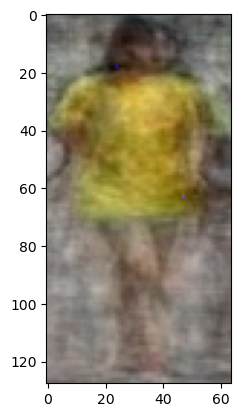

Original Image


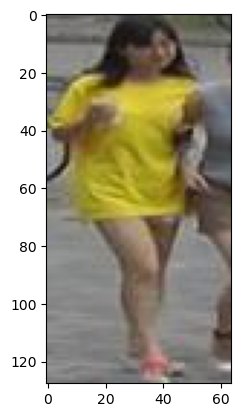

In [26]:
def reconstruct_image(compressed_image, F, Q_norms, A_means):
    # YOUR CODE HERE
    img = F @ compressed_image
    R = (img * Q_norms + A_means).reshape(dimension).astype(np.uint8)
    
    return R

#Display Code. Leave it alooooooooooone.
R_c = reconstruct_image(compressed_image, F, Q_norms, A_means)
print('Compressed Image: ')
plt.imshow(R_c)
plt.show()
Img = A[:, Idx]
R_o = A_pp[:, Idx].reshape(dimension)
print('Original Image')
plt.imshow(R_o)
plt.show()

# Two images should look similar. The compressed image may be a little more blurry.

Now, lets using the tool to do a simple classification task.

**TASK 1.5:** Complete the function: 

$$the\_nearest\_image(query\_image,gallery\_images, k, F, D, A\_means, Q\_norms) = index\_of\_the\_nearest\_image$$

Using the function in Task 1.3 to project an image vector onto the $k$ eigen pedestrians corresponding to the $k$ largest eigen values. 
Use this projection for a nearest-neighbour search over all the 90 persons. Returns the index of the nearest image.

The index of the first image is zero. 

**HINT:** 
- $query\_image$ and $gallery\_images$ are not preprocessed.
- First you need to calculate all compressed image, then make search.
- Using Euclidean distance to calculate the distance between two vectors.

(24576,) (24576, 90)


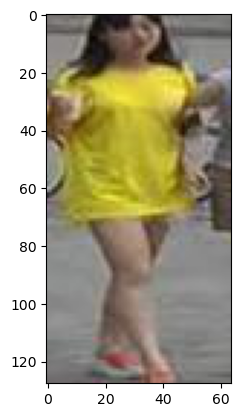

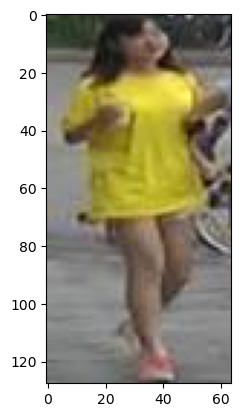

In [27]:
def the_nearest_image(query_image, gallery_images, k, F, D, A_means, Q_norms):
    # YOUR CODE HERE
    print(query_image.shape, gallery_images.shape)
    compressed_query_img = reduce_dimensionality(query_image, k, F, D, A_means, Q_norms)[0]
    compressed_gallery_imgs = np.array([reduce_dimensionality(g_img, k, F, D, A_means, Q_norms)[0] for g_img in gallery_images.T])
    index_of_the_nearest_image = np.argmin(np.linalg.norm(compressed_gallery_imgs - compressed_query_img, axis=1))

    return index_of_the_nearest_image

# Display Code. Leave it alooooooooooone.
# read a query image
query_image = imread("./val_query/0227_c2s1_046476_01.jpg")
query_image = query_image.flatten()

# read gallery images
gallery_images = []
original_gallery_images = []
filename = []
for file in os.listdir("./gallery"):
    if file.endswith(".jpg"):
        im = imread("./gallery/" + file)
        original_gallery_images.append(im)
        im = im.flatten() # flatten im into a vector
        gallery_images.append(im) 
        filename.append(file)
        
original_gallery_images = np.array(original_gallery_images)
gallery_images = np.stack(gallery_images).T

idx = the_nearest_image(query_image, gallery_images, 80, F, D, A_means, Q_norms)
plt.imshow(query_image.reshape(dimension))
plt.show()
plt.imshow(gallery_images[:, idx].reshape(dimension))
plt.show()

**TASK 2:** Complete the function
   
$$image\_similarity\_ranking(image\_gallery, query) = list\_of\_index\_of\_the\_images$$

Image_gallery is the collection of all 90 images with dimension $90 \times 128 \times 64 \times 3$.

Query is one image with dimension $128 \times 64 \times 3$.

Unlike Task 1.5, the return value should be a list filled with indices. The index should correspond to the sorted gallery images according to their similarities with the query. That is, the first element in the index corresponds to the image with the highest similarity to the query. The second element in the index corresponds to the image with second highest similarity to the query, etc. The length of the result should be 90, same as the number of gallery images. **The indices of the images in the gallery start from zero**. 


**Requirements:** 
- Use pixels of images as features.
- Use PCA algorithm you implemented in Task 1.3 to reduce the dimensions of features.
- You are free to tune the dimensions of the features after dimensionality reduction.
- You are free to improve the distance metrics.

Marking criteria: We have a testing set that you are not allowed to access. Our evaluation process will calculate a matching score, a weighted sum of your top-1, 2, 3, 4, 5 accuracy using some test queries (not provided to students). These test queries will be used to probe your gallery data (90 images). Top-k accuracy measures the percentage of queries for which you could find the true match within the top-k position of the rank list. Your mark will be given based on your accuracy. For example, if your implementation is better than the baseline, say a 9.5 accuracy on testing set, you will receive 20 marks; If your accuracy is lower than the baseline, you will get 10 marks. If your program contains errors/bugs, you will receive 0. 


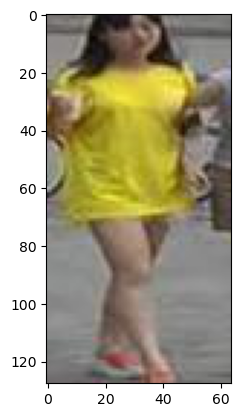

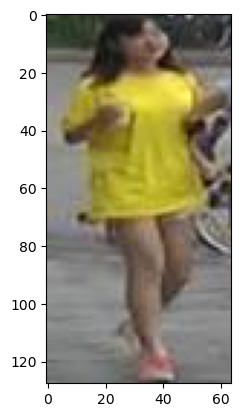

In [28]:
def image_similarity_ranking(image_gallery, image_query):
    # YOUR CODE HERE
    k = 50
    img_query = image_query.flatten()
    img_gallery = image_gallery.reshape(image_gallery.shape[0], -1).T
    compressed_query_img = reduce_dimensionality(img_query, k, F, D, A_means, Q_norms)[0]
    compressed_gallery_imgs = np.array([reduce_dimensionality(g_img, k, F, D, A_means, Q_norms)[0] for g_img in img_gallery.T])
    list_of_index_of_the_images = np.argsort(np.linalg.norm(compressed_gallery_imgs - compressed_query_img, axis=1))
    
    return list_of_index_of_the_images

# Display Code. Leave it alooooooooooone.

id_list = image_similarity_ranking(original_gallery_images, imread("./val_query/0227_c2s1_046476_01.jpg"))

plt.imshow(imread("./val_query/0227_c2s1_046476_01.jpg"))
plt.show()
plt.imshow(original_gallery_images[id_list[0]])
plt.show()

In [29]:
def match_score(name, rr):
    def reid(idx):
        return filename[rr[idx]][:4]
    base = 0.0
    code = name[:4]
    if reid(0) == code or reid(1) == code or reid(2) == code:
        base += 0.4
        if (reid(0) == code):
            base += 0.3
        elif (reid(1) == code):
            base += 0.2
        elif (reid(2) == code):
            base += 0.1
        if (reid(0) == code and reid(1) == code) or (reid(0) == code and reid(2) == code) or (reid(1) == code and reid(2) == code):
            base += 0.2
            if (reid(0) == code and reid(1) == code and reid(2) == code):
                base += 0.1
    else:
        if (reid(3) == code):
            base += 0.4
        elif (reid(4) == code):
            base += 0.2
    return base

def total_score():
    score = 0
    for file in os.listdir("./val_query"):
        rr = image_similarity_ranking(original_gallery_images, imread("./val_query/" + file))
        #_, rr = the_nearest_image(imread("./test/" + file).flatten(), A_pp, 30, F, D, A_means, Q_norms)
        score += match_score(file, rr)
    return score
total_score()

2.9999999999999996